# Imports and installs

In [1]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 41kB/s 
     |████████████████████████████████| 3.1MB 42.6MB/s 
     |████████████████████████████████| 501kB 54.4MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import time
import itertools
import math

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Dataset
In the generel terminology of the paper, the dataset consists of tasks, with each task containing a sine-wave function, that can be sampled for K datapoints. Sine waves vary in amplitude and phase, which are sampled in the following ranges:
- amplitude: 0.1 - 5.0
- phase: 0.0 - $\pi$
- the K samples (x values): -5.0 - 5.0

The TaskGenerator generates tasks (unsurprisingly), with each task having a fixed amplitude and phase value.

In [0]:
class TaskGenerator():
    def __init__(self, k_shot, amplitude=None, phase=None):
        self.K =  k_shot
        self.sample_range = (-5.0, 5.0)
        
        # set amplitude and phase to specified values OR choose randomly
        self.amplitude = amplitude if amplitude is not None else np.random.uniform(0.1, 5.0)
        self.phase = phase if phase is not None else np.random.uniform(0.0, np.pi)

    def sine(self, x, amplitude=None, phase=None):
        """Sine wave"""
        amplitude = amplitude if amplitude else self.amplitude
        phase = phase if phase else self.phase
        return amplitude * np.sin((x + phase))
    
    def _add_batch_dim(self, x, y):
        """ Treat every datapoint as it's own batch """ 
        return x.reshape((-1,1)), y.reshape((-1,1))

    def sample_linspace(self, N=100):
        start, stop = self.sample_range
        x = np.linspace(start, stop, num=N)
        y = self.sine(x)
        
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        
        return self._add_batch_dim(x,y)
    
    def sample(self):
        start, stop = self.sample_range
        x = np.random.uniform(start, stop, size=self.K)
        x = np.sort(x) # convenience for plotting, points in ascending order
        y = self.sine(x)
        
        # Convert to match network output
        # Maybe only relevant if running on GPU
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        
        return self._add_batch_dim(x,y)


Example of 3 different tasks, with sine waves and K samples from each.

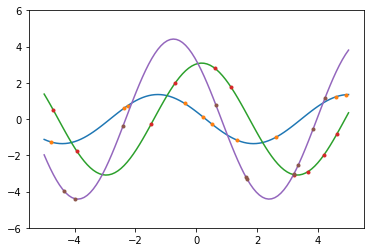

In [5]:
for _ in range(3):
    task = TaskGenerator(k_shot=10)
    x, y = task.sample()
    x_full, y_full = task.sample_linspace()
    plt.plot(x_full, y_full, '-')
    plt.plot(x, y, '.')

plt.ylim(-6,6)
plt.show()

In [0]:
class Dataset():
    def __init__(self, data):
        self.data = data
    
    def size(self):
        return len(self.data)
    
    def shuffle(self):
        np.random.shuffle(self.data)
    
    def batch(self, batch_size):
        assert batch_size > 0 and batch_size <= len(self.data), "Weird batch_size!"
        
        # shuffle data and pick batch_size from beginning
        np.random.shuffle(self.data)
        return self.data[: batch_size]
    

In [0]:
def create_train_test_datasets(K=10, N=100, test_size_percent=0.1):
    # sample N points in amplitude and phase ranges
    a_vals = np.around( np.linspace(0.1, 5.0, num=N),   4)
    p_vals = np.around( np.linspace(0.0, np.pi, num=N), 4)

    # create all pairs of (amplitude, phase) values
    amplitude_phase_pairs = list(itertools.product(a_vals, p_vals))

    # shuffle them
    np.random.shuffle(amplitude_phase_pairs)

    # find test size
    test_size = len(a_vals) * len(p_vals) * test_size_percent
    test_size = math.floor(test_size)

    # map all (amplitude, phase) pairs to a TaskGenerator
    all_tasks = list(map(lambda a_p: TaskGenerator(k_shot=K, amplitude=a_p[0], phase=a_p[1]),
       amplitude_phase_pairs))

    # create train and test set
    test  = all_tasks[ : test_size]
    train = all_tasks[test_size : ]
    
    print("Train size:", len(train))
    print("Test size:", len(test))
    
    train_dataset = Dataset(train)
    test_dataset = Dataset(test)
    
    return train_dataset, test_dataset


In [8]:
train_ds, test_ds = create_train_test_datasets()

Train size: 9000
Test size: 1000


# Models

## Sine model

In [9]:
def create_sine_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, input_shape=(1,), activation="relu"),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    return model

model_tmp = create_sine_model()
model_tmp.summary()
del model_tmp

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [10]:
for layer in create_sine_model().layers:
    print(layer.kernel.shape, layer.bias.shape)

(1, 20) (20,)
(20, 20) (20,)
(20, 1) (1,)


## Parameter generator model: K inputs --> weights

In [0]:
from tensorflow.keras.layers import Dense

def create_latent_models():
    K = 10
    input_dim = (2*K,)
    latent_dim = 16
    

    # out_act = "sigmoid"
    # out_act = "relu"
    out_act = "tanh"
    # out_act = "linear"
    
    hidden_act = "relu"
    #hidden_act = None
    #hidden_act = "sigmoid"
    
    bias_init = "ones"
    

    input_layer = Input(shape=input_dim, name="encoder_input")

    # encoder
    x = Dense(32, name="enc_1", bias_initializer=bias_init, activation=hidden_act)(input_layer)
    x = Dense(32, name="enc_2", bias_initializer=bias_init, activation=hidden_act)(x)
    x = Dense(32, name="enc_3", bias_initializer=bias_init, activation=hidden_act)(x)
    encoded = Dense(latent_dim, name="encoded", bias_initializer=bias_init, activation=hidden_act)(x)

    # decoder
    h1 = Dense(32, name="dec_1", bias_initializer=bias_init, activation=hidden_act)
    h2 = Dense(32, name="dec_2", bias_initializer=bias_init, activation=hidden_act)

    d1 = Dense(20,  name="w1", activation=out_act)
    d2 = Dense(20,  name="b1", activation=out_act)
    d3 = Dense(400, name="w2", activation=out_act)
    d4 = Dense(20,  name="b2", activation=out_act)
    d5 = Dense(20,  name="w3", activation=out_act)
    d6 = Dense(1,   name="b3", activation=out_act)

    _h1 = h1(encoded)
    _h2 = h2(_h1)

    _d1 = d1(_h2)
    _d2 = d2(_h2)
    _d3 = d3(_h2)
    _d4 = d4(_h2)
    _d5 = d5(_h2)
    _d6 = d6(_h2)


    full_model = Model(inputs=input_layer, outputs=[_d1,_d2,_d3,_d4,_d5,_d6])

    encoder = Model(inputs=input_layer, outputs=encoded)

    # separate decoder model
    decoder_input = Input(shape=(latent_dim,), name="decoder_input")
    __h1 = h1(decoder_input)
    __h2 = h2(__h1)

    __d1 = d1(__h2)
    __d2 = d2(__h2)
    __d3 = d3(__h2)
    __d4 = d4(__h2)
    __d5 = d5(__h2)
    __d6 = d6(__h2)

    decoder = Model(inputs=decoder_input, outputs=[__d1,__d2,__d3,__d4,__d5,__d6])
    return encoder, decoder, full_model

encoder, decoder, full_model = create_latent_models()


In [12]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
enc_1 (Dense)                   (None, 32)           672         encoder_input[0][0]              
__________________________________________________________________________________________________
enc_2 (Dense)                   (None, 32)           1056        enc_1[0][0]                      
__________________________________________________________________________________________________
enc_3 (Dense)                   (None, 32)           1056        enc_2[0][0]                      
______________________________________________________________________________________________

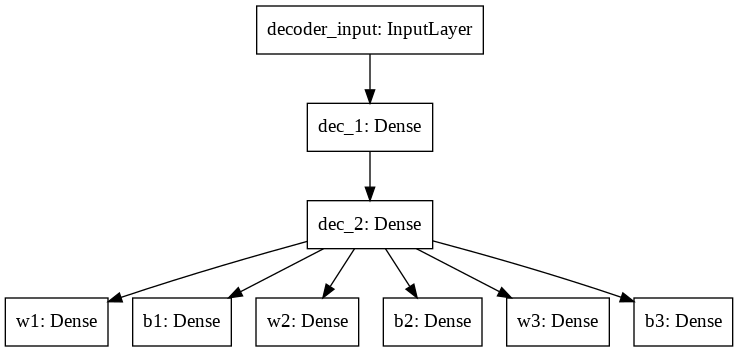

In [13]:
plot_model(decoder)

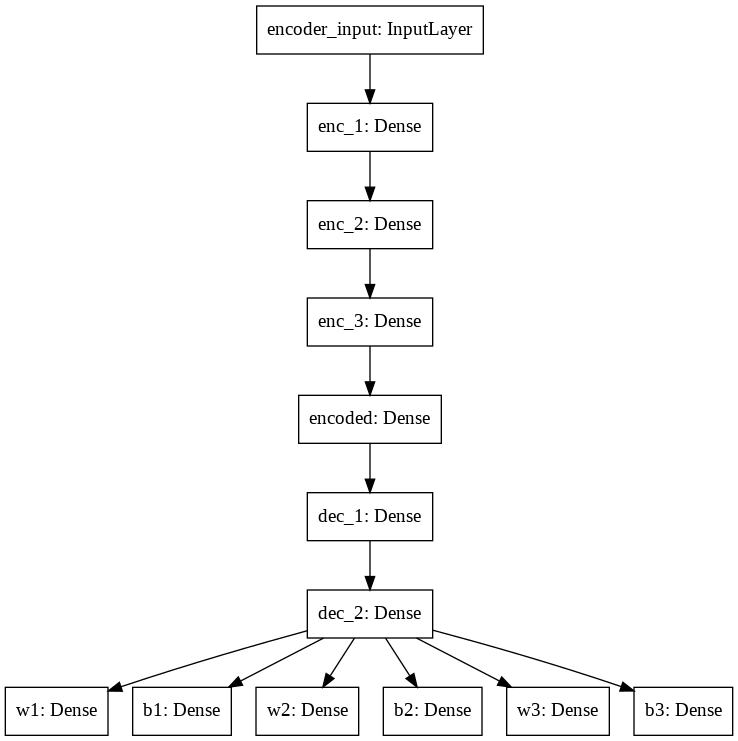

In [14]:
plot_model(full_model)

# Utils

In [0]:

def apply_weights(weights, model):
    j = 0
    for i in range( len(model.layers) ):
        kernel_shape = model.layers[i].kernel.shape
        model.layers[i].kernel = tf.reshape(weights[j], kernel_shape)

        bias_shape = model.layers[i].bias.shape
        model.layers[i].bias = tf.reshape(weights[j+1], bias_shape)

        j += 2

        
def loss_func(y_true, y_pred):
    sqr_diff = tf.math.squared_difference(y_true, y_pred)
    return sqr_diff

def compute_loss(x, y, sine_model, weights, loss_fn=loss_func):
    apply_weights(weights, sine_model)
    y_pred = sine_model(x)
    loss = loss_func(y, y_pred)
    return tf.reduce_mean( loss )

def compute_meta_loss(x, y, sine_model, weights, z, z_, loss_fn=loss_func):
    apply_weights(weights, sine_model)
    y_pred = sine_model(x)
    loss = loss_func(y, y_pred)
    mean_loss = tf.reduce_mean( loss )
    
    # extra loss, on the z encodings
    z_loss = tf.reduce_mean(tf.math.squared_difference(z, tf.stop_gradient(z_))) * 0.001
    
    return mean_loss + z_loss


   
def copy_model(model, create_model_fn):
    """ Create a model of the predefined similar architecture 
        and copy the weights 
    """
    model_copy = create_model_fn()
    model_copy.set_weights( model.get_weights() )
    return model_copy


# Training

## Always guessing y = 0 (sanity check baseline)

In [0]:
means = []
for task in train_ds.data:
    x,y = task.sample()
    mean = tf.reduce_mean(loss_func(y, np.zeros((10,1))))
    means.append(mean)

# tf.reduce_mean(means).numpy()
np.mean(men)


AttributeError: ignored

In [0]:
np.mean(means)

AttributeError: ignored

## Pseudo code implementation

Without the relation net

### Pseudo code - not working

In [0]:

# 1: initiaize networks
encoder, decoder, full_model = create_latent_models()


alpha = 0.001
beta = 0.001

optimizer = tf.keras.optimizers.Adam(beta)

log_step = 100
num_adaptations = 3

EPOCHS = 10
DATASET_SIZE = 100


start_time = time.time()
# 3/4
for e in range(EPOCHS):
    losses = []
    total_loss = 0.0
    train_ds.shuffle()
    
    for task in train_ds.data[ : DATASET_SIZE]:
        x,y = task.sample()
        x_meta, y_meta = task.sample()

        # 7: Encode D^tr to z using g_encoder
        # combine x and y and reshape to match encoder input shape
        x_y = tf.concat([x,y], axis=0)
        x_y = tf.reshape(x_y, (1,20))

        with tf.GradientTape() as meta_tape:
            # 5 + 6
            sine_model = create_sine_model()
            with tf.GradientTape(persistent=True) as train_tape:
                z = encoder(x_y)
                # 8: Decode z to initial Ø using decoder
                w = decoder(z)
                # 9: Init: z' = z, Ø' = Ø
                z_ = z
                w_ = w
                # 10
                for j in range(num_adaptations):
                    # 11: compute training loss
                    train_loss = compute_loss(x, y, sine_model, w_)

                    # 12: Perform gradient descent wrt z' on train loss
                    train_gradients = train_tape.gradient(train_loss, z_)
                    #print("z", z)
                    z_ = tf.subtract(z_, tf.multiply(alpha, train_gradients))
                    #print("z_", z_)

                    # 13: decode z' to Ø' using decoder        
                    w_ = decoder(z_)

            #train_loss_2 = compute_loss(x, y, sine_model, w_)
            #print("train loss after", train_loss_2.numpy())
            #break

            # 15: compute validation loss
            meta_loss = compute_loss(x_meta, y_meta, sine_model, w_)
            # meta_loss = compute_loss(x, y, sine_model, w_)

            # meta_loss = compute_meta_loss(x_meta, y_meta, sine_model, w_, z, z_)
            losses.append(meta_loss)

        # 17: perform gradient descent wrt ø (encoder + decoder params)
        # meta_gradients = meta_tape.gradient(meta_loss, full_model.trainable_variables)
        # optimizer.apply_gradients( zip(meta_gradients, full_model.trainable_variables) )

        # TRY ONLY TRAINING ENCODER
        meta_gradients = meta_tape.gradient(meta_loss, encoder.trainable_variables)
        optimizer.apply_gradients( zip(meta_gradients, encoder.trainable_variables) )

        total_loss += meta_loss.numpy()
        # loss = total_loss / ( len(losses) + 1 )
        loss = total_loss / ( len(losses) )
    
    time_spent = time.time() - start_time
    print(e, "-", loss, "-", np.around(time_spent, 2))
    start_time = time.time()


### batches - working

In [0]:

# 1: initiaize networks
encoder, decoder, full_model = create_latent_models()


alpha = 0.001
beta = 0.001

optimizer = tf.keras.optimizers.Adam(beta)

log_step = 100
num_adaptations = 3

EPOCHS = 10
DATASET_SIZE = 100
BATCHES_IN_EPOCH = 10
BATCH_SIZE = 4


start_time = time.time()

for e in range(EPOCHS):
    losses = []
    total_loss = 0.0
    train_ds.shuffle()
    
    for i in range(BATCHES_IN_EPOCH):
        with tf.GradientTape() as meta_tape:
            meta_losses = []
            for task in train_ds.batch(BATCH_SIZE):
                x,y = task.sample()
                x_meta, y_meta = task.sample()
                x_y = tf.concat([x,y], axis=0)
                x_y = tf.reshape(x_y, (1,20))

                sine_model = create_sine_model()
                with tf.GradientTape(persistent=True) as train_tape:
                    z = encoder(x_y)
                    w = decoder(z)
                    z_ = z
                    w_ = w
                    for j in range(num_adaptations):
                        train_loss = compute_loss(x, y, sine_model, w_)
                        train_gradients = train_tape.gradient(train_loss, z_)
                        z_ = tf.subtract(z_, tf.multiply(alpha, train_gradients))
                        w_ = decoder(z_)

                meta_loss = compute_loss(x_meta, y_meta, sine_model, w_)
                # meta_loss = compute_meta_loss(x_meta, y_meta, sine_model, w_, z, z_)
                meta_losses.append(meta_loss)

            batch_loss = tf.reduce_mean(meta_losses)
        # 17: perform gradient descent wrt ø (encoder + decoder params)
        # meta_gradients = meta_tape.gradient(meta_loss, full_model.trainable_variables)
        # optimizer.apply_gradients( zip(meta_gradients, full_model.trainable_variables) )

        # TRY ONLY TRAINING ENCODER
        meta_gradients = meta_tape.gradient(batch_loss, encoder.trainable_variables)
        optimizer.apply_gradients( zip(meta_gradients, encoder.trainable_variables) )

        losses.append(batch_loss.numpy())
        
        total_loss += batch_loss.numpy()
        # loss = total_loss / ( len(losses) + 1 )
        loss = total_loss / ( len(losses) )
    
    time_spent = time.time() - start_time
    print(e, "-", loss, "-", np.around(time_spent, 2))
    start_time = time.time()


### Batches - samples INSIDE GradientTape

In [0]:
#@tf.function
def inner_loop(encoder, decoder, sine_model, task, num_adaptations):
    x,y = task.sample()
    x_y = tf.concat([x,y], axis=0)
    x_y = tf.reshape(x_y, (1,20))
    
    with tf.GradientTape(persistent=True) as train_tape:
        z = encoder(x_y)
        w = decoder(z)
        for j in range(num_adaptations):
            train_loss = compute_loss(x, y, sine_model, w)
            train_gradients = train_tape.gradient(train_loss, z)
            z = tf.subtract(z, tf.multiply(alpha, train_gradients))
            w = decoder(z)
    return w

#@tf.function
def batch_training_step(batch, encoder, decoder, sine_model, alpha, optimizer):
    with tf.GradientTape() as meta_tape:
        meta_losses = []
        for task in batch:
            w_ = inner_loop(encoder, decoder, sine_model, task, num_adaptations)
            
            x_meta, y_meta = task.sample()
            meta_loss = compute_loss(x_meta, y_meta, sine_model, w_)
            meta_losses.append(meta_loss)

        batch_loss = tf.reduce_mean(meta_losses)
    meta_gradients = meta_tape.gradient(batch_loss, full_model.trainable_variables)
    optimizer.apply_gradients( zip(meta_gradients, full_model.trainable_variables) )
    
    #return batch_loss.numpy()
    return batch_loss




In [17]:

# 1: initiaize networks
encoder, decoder, full_model = create_latent_models()


alpha = 0.001
beta = 0.001

optimizer = tf.keras.optimizers.Adam(beta)

log_step = 100
num_adaptations = 3

EPOCHS = 25
# DATASET_SIZE = 100
BATCHES_IN_EPOCH = 50
BATCH_SIZE = 4


start_time = time.time()

for e in range(EPOCHS):
    # reset losses in new epoch
    losses = []
    total_loss = 0.0
    train_ds.shuffle()
    
    for i in range(BATCHES_IN_EPOCH):
        batch = train_ds.batch(BATCH_SIZE)
        
        sine_model = create_sine_model()
        batch_loss = batch_training_step(batch, encoder, decoder, sine_model, alpha, optimizer)
        #np_batch_loss = batch_loss.numpy()
        
        #losses.append(np_batch_loss)
        #total_loss += np_batch_loss
        losses.append(batch_loss)
        total_loss += batch_loss
        
        loss = total_loss / ( len(losses) )
    
    time_spent = time.time() - start_time
    print(e, "-", loss, "-", np.around(time_spent, 2))
    start_time = time.time()


0 - tf.Tensor(14.449987, shape=(), dtype=float32) - 16.87
1 - tf.Tensor(4.4283357, shape=(), dtype=float32) - 16.68
2 - tf.Tensor(3.893181, shape=(), dtype=float32) - 16.84
3 - tf.Tensor(3.5582364, shape=(), dtype=float32) - 17.42
4 - tf.Tensor(3.786873, shape=(), dtype=float32) - 16.56
5 - tf.Tensor(3.0120056, shape=(), dtype=float32) - 16.83
6 - tf.Tensor(2.5705607, shape=(), dtype=float32) - 17.15
7 - tf.Tensor(2.4364834, shape=(), dtype=float32) - 17.13
8 - tf.Tensor(1.8492755, shape=(), dtype=float32) - 16.96
9 - tf.Tensor(2.3581955, shape=(), dtype=float32) - 17.11
10 - tf.Tensor(1.9966916, shape=(), dtype=float32) - 17.02
11 - tf.Tensor(1.3557881, shape=(), dtype=float32) - 17.07
12 - tf.Tensor(1.5349107, shape=(), dtype=float32) - 16.93
13 - tf.Tensor(1.1969155, shape=(), dtype=float32) - 17.04
14 - tf.Tensor(1.8650491, shape=(), dtype=float32) - 17.33
15 - tf.Tensor(1.4211993, shape=(), dtype=float32) - 16.64
16 - tf.Tensor(1.6519649, shape=(), dtype=float32) - 17.21
17 - tf.T

### Batches - samples OUTSIDE GradientTape

In [0]:
# @tf.function
def inner_loop(encoder, decoder, sine_model, x, y, num_adaptations):
    x_y = tf.concat([x,y], axis=0)
    x_y = tf.reshape(x_y, (1,20))
    
    with tf.GradientTape(persistent=True) as train_tape:
        z = encoder(x_y)
        w = decoder(z)
        z_ = z
        w_ = w
        for j in range(num_adaptations):
            train_loss = compute_loss(x, y, sine_model, w_)
            train_gradients = train_tape.gradient(train_loss, z_)
            z_ = tf.subtract(z_, tf.multiply(alpha, train_gradients))
            w_ = decoder(z_)
    return w_


# @tf.function
def batch_training_step(batch, encoder, decoder, sine_model, alpha, optimizer, xs_ys, xs_ys_meta):
    with tf.GradientTape() as meta_tape:
        meta_losses = []
        # for x,y in xs_ys:
        for xys,xys_meta in zip(xs_ys,xs_ys_meta):
            x,y = xys
            x_meta, y_meta = xys_meta
            
            w_ = inner_loop(encoder, decoder, sine_model, x, y, num_adaptations)
            
            meta_loss = compute_loss(x_meta, y_meta, sine_model, w_)
            # meta_loss = compute_loss(x, y, sine_model, w_)
            meta_losses.append(meta_loss)

        batch_loss = tf.reduce_mean(meta_losses)
    meta_gradients = meta_tape.gradient(batch_loss, full_model.trainable_variables)
    optimizer.apply_gradients( zip(meta_gradients, full_model.trainable_variables) )
    
    #return batch_loss.numpy()
    return batch_loss


In [24]:

# 1: initiaize networks
encoder, decoder, full_model = create_latent_models()


alpha = 0.001
beta = 0.001

optimizer = tf.keras.optimizers.Adam(beta)

log_step = 100
num_adaptations = 3

EPOCHS = 25
BATCHES_IN_EPOCH = 50
BATCH_SIZE = 4


start_time = time.time()

for e in range(EPOCHS):
    losses = []
    total_loss = 0.0
    train_ds.shuffle()
    
    for i in range(BATCHES_IN_EPOCH):
        batch = train_ds.batch(BATCH_SIZE)
        
        xs_ys = map(lambda task: task.sample(), batch)
        xs_ys_meta = map(lambda task: task.sample(), batch)
        
        sine_model = create_sine_model()
        batch_loss = batch_training_step(batch, encoder, decoder, sine_model, alpha, optimizer, xs_ys, xs_ys_meta)
        #np_batch_loss = batch_loss.numpy()
        
        #losses.append(np_batch_loss)
        #total_loss += np_batch_loss
        losses.append(batch_loss)
        total_loss += batch_loss
        loss = total_loss / ( len(losses) )
    
    time_spent = time.time() - start_time
    print(e, "-", loss, "-", np.around(time_spent, 2))
    start_time = time.time()


0 - tf.Tensor(13.465571, shape=(), dtype=float32) - 16.76
1 - tf.Tensor(4.10349, shape=(), dtype=float32) - 17.8
2 - tf.Tensor(4.0898695, shape=(), dtype=float32) - 16.87
3 - tf.Tensor(3.2888482, shape=(), dtype=float32) - 17.02
4 - tf.Tensor(3.0409033, shape=(), dtype=float32) - 18.11
5 - tf.Tensor(2.8752384, shape=(), dtype=float32) - 18.1
6 - tf.Tensor(3.2480264, shape=(), dtype=float32) - 17.67
7 - tf.Tensor(2.5544891, shape=(), dtype=float32) - 18.37
8 - tf.Tensor(2.4764748, shape=(), dtype=float32) - 17.27
9 - tf.Tensor(2.516612, shape=(), dtype=float32) - 16.54
10 - tf.Tensor(1.6067665, shape=(), dtype=float32) - 18.08
11 - tf.Tensor(1.7924403, shape=(), dtype=float32) - 17.2
12 - tf.Tensor(1.7927573, shape=(), dtype=float32) - 17.21
13 - tf.Tensor(2.186656, shape=(), dtype=float32) - 17.16
14 - tf.Tensor(1.9775065, shape=(), dtype=float32) - 18.67
15 - tf.Tensor(1.5662504, shape=(), dtype=float32) - 17.38
16 - tf.Tensor(1.4284843, shape=(), dtype=float32) - 17.02
17 - tf.Tensor

### Evaluation

LOAD weights from pre-trained model

In [0]:
path_root = '/content/gdrive/My Drive/Colab Notebooks/speciale/LEO/'
# names for saving and loading models
baseline_name = "baseline_regression_weights_K10_9000train.h5"
maml_name = "maml_regression_weights_K10_9000train.h5"
file_name = "full_weights_1566849005.h5"


In [0]:
full_model.load_weights(path_root + file_name)

In [31]:
# EVALUATION
num_adaptations = 3
alpha = 0.001

test_losses = []
for i, task in enumerate(test_ds.data):
    sine_model = create_sine_model()
    x, y = task.sample()
    x_full, y_full = task.sample_linspace()

    # combine x and y and reshape to match encoder input shape
    x_y = tf.concat([x,y], axis=0)
    x_y = tf.reshape(x_y, (1,20))


    with tf.GradientTape(persistent=True) as train_tape:
        z_ = encoder(x_y)
        w_ = decoder(z_)

        for j in range(num_adaptations):
            # 11: compute training loss
            train_loss = compute_loss(x, y, sine_model, w_)

            # 12: Perform gradient descent wrt z' on train loss
            train_gradients = train_tape.gradient(train_loss, z_)
            z_ = tf.subtract(z_, tf.multiply(alpha, train_gradients))

            # 13: decode z' to Ø' using decoder        
            w_ = decoder(z_)
    test_loss = compute_loss(x_full, y_full, sine_model, w_)
    test_losses.append(test_loss)
    
    print(i, test_loss.numpy())
    


0 0.13433728
1 0.05133979
2 0.011164621
3 0.02451114
4 0.036749892
5 0.71140015
6 0.017581452
7 0.007809639
8 1.2929046
9 0.01080423
10 0.039765935
11 0.7974118
12 0.063990735
13 0.14375506
14 0.02425736
15 0.0137275625
16 0.024979375
17 0.02870883
18 0.19451495
19 0.018331166
20 0.030428724
21 0.9815188
22 0.12508468
23 0.010990185
24 0.22179237
25 0.3772866
26 0.02535933
27 0.08648183
28 0.16682549
29 0.16410242
30 0.12677936
31 0.051831517
32 0.119773865
33 0.14883709
34 0.014124206
35 0.05111105
36 0.084958255
37 0.011415524
38 0.018430611
39 0.048263025
40 0.0063016885
41 0.059726402
42 0.08577339
43 0.018173497
44 0.013468959
45 0.04792793
46 0.07643448
47 0.15783878
48 0.2732088
49 0.009050019
50 0.011766075
51 0.04364988
52 0.02440002
53 0.6759804
54 0.032228854
55 0.0074528363
56 0.01844532
57 0.03600612
58 0.016792376
59 0.19672531
60 0.080695726
61 0.025689745
62 0.5317247
63 0.0071697687
64 0.15947874
65 0.029763568
66 0.0151079055
67 0.16317463
68 0.034356024
69 0.03174136

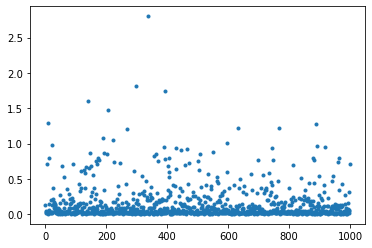

In [32]:
plt.plot(test_losses, '.')

# Evaluation

In [0]:


# forward model

def forward_pass(w, sine_model, x):
    apply_weights(w, sine_model)
    y_pred = sine_model(x)
    return y_pred


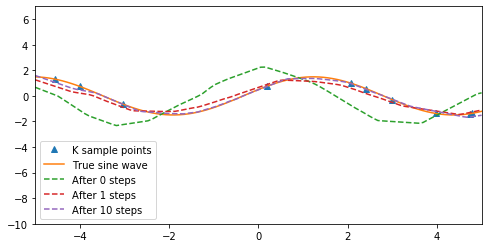

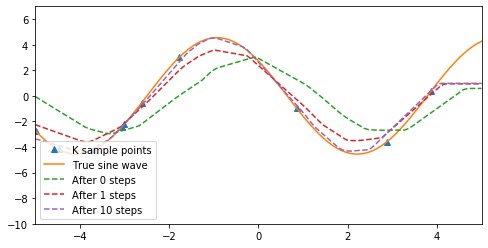

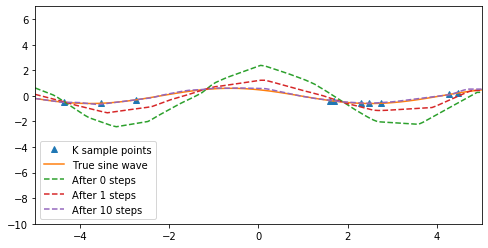

In [42]:


num_plots = 3
gradient_updates = {0,1,10}

sine_model = create_sine_model()
alpha = 0.001 #0.001

for _ in range(num_plots):
    task = TaskGenerator(k_shot=10)
    x, y = task.sample()
    x_full, y_full = task.sample_linspace()

    predictions = {k: [] for k in gradient_updates}
    
    x_y = tf.concat([x,y], axis=0)
    x_y = tf.reshape(x_y, (1,20))

    with tf.GradientTape(persistent=True) as train_tape:
        z_ = encoder(x_y)
        w_ = decoder(z_)
        for update in range(0, max(gradient_updates)+1):
            # save prediction
            if update in gradient_updates:
                predictions[update] = forward_pass(w_, sine_model, x_full)

            # update model
            train_loss = compute_loss(x, y, sine_model, w_)
            train_gradients = train_tape.gradient(train_loss, z_)
            z_ = tf.subtract(z_, tf.multiply(alpha, train_gradients))
            w_ = decoder(z_)
        


    fig = plt.figure(figsize=(8,4))
    plt.ylim(-10,7)
    plt.xlim(-5,5)
    #plt.ylim(-10,5)
    #plt.xlim(-5,5)

    plt.plot(x, y, '^', label='K sample points')
    plt.plot(x_full, y_full, '-', label='True sine wave')
    for update in gradient_updates:
        plt.plot(x_full, predictions[update], '--', label=f'After {update} steps')    
    plt.legend(loc='lower left')
    plt.show()